# Example 2: Introduction to block MCMC sampling
## Overview
The goal of this example is to demonstrate MCMC sampling with block updates.
The problem is to sample a Gaussian distribution where the variance of
the Gaussian is a random variable endowed with an inverse Gamma distribution.
Thus, there are two "blocks" of interest: the Gaussian random variable and the
variance hyperparameter.  We will sample the joint distribution of both parameters
by constructing a Metropolis-Within-Gibbs sampler.

### Problem Formulation
Let $x$ denote the Gaussian random variable and $\sigma^2$ its
variance, which follows an Inverse Gamma distribution.  Notice that the joint
density $\pi(x,\sigma)$ can be expanded in two ways:
$$
\pi(x,\sigma^2) = \pi(x | \sigma^2)\pi(\sigma^2)
$$
and
$$
\pi(x,\sigma^2) = \pi(\sigma^2 | x)\pi(x).
$$
We will use this to simplify the Metropolis-Hastings acceptance ratios below.


Now consider a two stage Metropolis-Hastings algorithm.  In the first stage
we take a step in $x$ with a fixed value of $\sigma^2$ and in the second stage
we take a step in $\sigma^2$ with a fixed value of $x$.  Using the Metropolis-Hastings
rule for each stage, the algorithm is given by

1. Update $x$

  a. Propose a step in the $x$ block, $x^\prime \sim q(x | x^{(k-1)}, \sigma^{(k-1)})$

  b. Compute the acceptance probability using the expanded joint density
  $$\begin{eqnarray}
  \gamma &=& \frac{\pi(x^\prime | \sigma^{(k-1)})\pi(\sigma^{(k-1)})}{\pi(x^{(k-1)} | \sigma^{(k-1)}) \pi(\sigma^{(k-1)})} \frac{q(x^{(k-1)} | x^\prime, \sigma^{(k-1)})}{q(x^\prime | x^{(k-1)}, \sigma^{(k-1)})} \\\\
         &=& \frac{\pi(x^\prime | \sigma^{(k-1)})}{\pi(x^{(k-1)} | \sigma^{(k-1)})} \frac{q(x^{(k-1)} | x^\prime, \sigma^{(k-1)})}{q(x^\prime | x^{(k-1)}, \sigma^{(k-1)})}
  \end{eqnarray}$$

  c. Take the step in the $x$ block: $x^{(k)} = x^\prime$ with probability $\min(1,\gamma)$, else $x^{(k)} = x^{(k-1)}$

2. Update $\sigma^2$

  a. Propose a step in the $\sigma^2$ block, $\sigma^\prime \sim q(\sigma | x^{(k)}, \sigma^{(k-1)})$

  b. Compute the acceptance probability using the expanded joint density
  $$\begin{eqnarray}
  \gamma &=& \frac{\pi(\sigma^\prime | x^{(k)})\pi(x^{(k)})}{\pi(\sigma^{(k-1)} | x^{(k)}) \pi(x^{(k)})} \frac{q(\sigma^{(k-1)} | \sigma^\prime, x^{(k)})}{q(\sigma^\prime | \sigma^{(k-1)}, x^{(k)})}. \\\\
         &=& \frac{\pi(\sigma^\prime | x^{(k)})}{\pi(\sigma^{(k-1)} | x^{(k)})} \frac{q(\sigma^{(k-1)} | \sigma^\prime, x^{(k)})}{q(\sigma^\prime | \sigma^{(k-1)}, x^{(k)})}.
  \end{eqnarray}$$

  c. Take the step in the $\sigma^2$ block: $\sigma^{(k)} = \sigma^\prime$ with probability $\min(1,\gamma)$, else $\sigma^{(k)} = \sigma^{(k-1)}$

The extra complexity of this two stage approach is warranted when one or both of the block proposals
$q(\sigma^\prime | \sigma^{(k-1)}, x^{(k)})$ and $q(x^\prime | x^{(k-1)}, \sigma^{(k-1)})$
can be chosen to match the condtiional target densities $\pi(\sigma^\prime | x^{(k)})$
and $\pi(x^\prime | \sigma^{(k-1)})$.  When $\pi(x | \sigma^2)$ is Gaussian
and $\pi(\sigma^2)$ is Inverse Gamma, as is the case in this example, the conditional target distribution $\pi(\sigma^2 | x)$ can be sampled
directly, allowing us to choose $q(\sigma^\prime | \sigma^{(k-1)}, x^{(k)}) = \pi(\sigma^\prime | x^{(k)})$.
This guarantees an acceptance probability of one for the $\sigma^2$ update.  Notice
that in this example, $\pi(x^\prime | \sigma^{(k-1)})$ is Gaussian and could also
be sampled directly.  For illustrative purposes however, we will mix a random
walk proposal on $x$ with an independent Inverse Gamma proposal on $\sigma^2$.

***
## Implementation
To sample the Gaussian target, the code needs to do four things:

1. Define the joint Gaussian-Inverse Gamma target density with two inputs and set up a sampling problem.

2. Construct the blockwise Metropolis-Hastings algorithm with a mix of random walk and Inverse Gamma proposals.

3. Run the MCMC algorithm.

4. Analyze the results.



### Import libraries

In [1]:
from IPython.display import Image
import numpy as np

import pymuqSamplingAlgorithms as pmsa
import pymuqModeling as pmm

ImportError: No module named 'pymuqSamplingAlgorithms'

### 1. Define the joint Gaussian-Inverse Gamma target density
  Here we need to construct the joint density $\pi(x | \sigma^2)\pi(\sigma^2)$.
  Combining models model components in MUQ is accomplished by creating a
  WorkGraph, adding components the graph as nodes, and then adding edges to
  connect the components and construct the more complicated model.  Once constructed,
  our graph should look like:

  <center>
    <img src="DocFiles/GraphImage.png" alt="Model Graph" style="width: 400px;"/>
  </center>

  Dashed nodes in the image correspond to model inputs and nodes with solid borders
  represent model components represented through a child of the ModPiece class.
  The following code creates each of the components and then adds them on to the
  graph.  Notice that when the ModPiece's are added to the graph, a node name is
  specified.  Later, we will use these names to identify structure in the graph
  that can be exploited to generate the Inverse Gamma proposal.  Note that the
  node names used below correspond to the names used in the figure above.

In [2]:
varPiece = pmm.IdentityOperator(1)

In previous examples, the only input to the Gaussian density was the parameter
  $x$ itself.  Here however, the variance is also an input.  The Gaussian class
  provides an enum for defining this type of extra input.  Avaialable options are

  - `Gaussian::Mean` The mean should be included as an input
  - `Gaussian::DiagCovariance` The covariance diagonal is an input
  - `Gaussian::DiagPrecision` The precision diagonal is an input
  - `Gaussian::FullCovariance` The full covariance is an input (unraveled as a vector)
  - `Gaussian::FullPrecision` The full precision is an input (unraveled as a vector)

  The `|` operator can be used to combine options.  For example, if both the mean and
  diagonal covariance will be inputs, then we could pass `Gaussian::Mean | Gaussian::DiagCovariance`
  to the Gaussian constructor.

  In our case, only the diagonal covariance will be an input, so we can simply use `Gaussian::DiagCovariance`.

In [29]:
mu = np.array([1.0, 2.0])
gaussDens = pmm.Gaussian(mu,pmm.Gaussian.DiagCovariance).AsDensity()

  Here we construct the Inverse Gamma distribution $\pi(\sigma^2)$

In [4]:
alpha = 2.5
beta = 1.0

varDens = pmm.InverseGamma(alpha,beta).AsDensity()

prodDens = pmm.DensityProduct(2)

The Gaussian density used here is two dimensional with the same variance in each
dimension.  The Gaussian ModPiece thus requires a two dimensional vector to define
the diagonal covariance.  To support that, we need to replicate the 1D vector
returned by the "varPiece" IdentityOperator.   The ReplicateOperator class
provides this functionality.

In [5]:
rep10p = pmm.ReplicateOperator(1,2)
graph = pmm.WorkGraph()

graph.AddNode(gaussDens, "Gaussian Density")
graph.AddNode(varPiece, "Variance")
graph.AddNode(varDens, "Variance Density")
graph.AddNode(prodDens, "Joint Density")
graph.AddNode(rep10p, "Replicated Variance")

graph.AddEdge("Variance", 0, "Replicated Variance", 0)
graph.AddEdge("Replicated Variance", 0, "Gaussian Density", 1)
graph.AddEdge("Variance", 0, "Variance Density", 0)

graph.AddEdge("Gaussian Density", 0, "Joint Density", 0)
graph.AddEdge("Variance Density", 0, "Joint Density", 1)

 #### Visualize the graph
To check to make sure we constructed the graph correctly, we will employ the
  WorkGraph::Visualize function.  This function generates an image in the folder
  where the executable was run.  The result will look like the image below.  Looking
  at this image closely, we see that, with the exception of the "Replicate Variance"
  node, the structure matches what we expect.

In [6]:
graph.Visualize("DensityGraph.png")

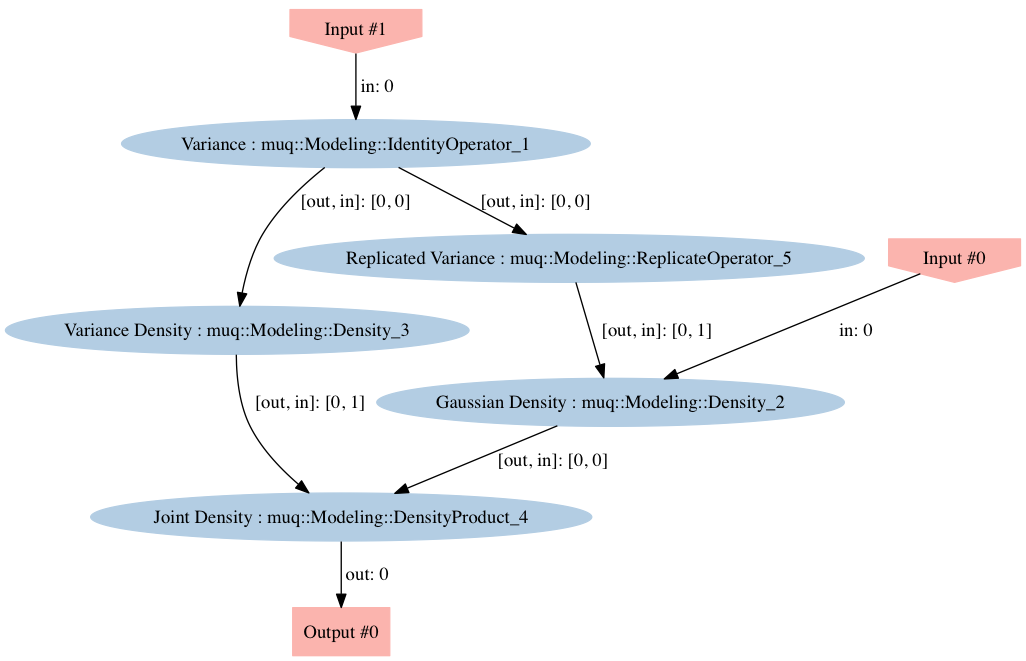

In [7]:
Image(filename='DocFiles/DensityGraph.png') 

 #### Construct the joint density model and sampling problem
  Here we wrap the graph into a single ModPiece that can be used to construct the
  sampling problem.

In [8]:
jointDens = graph.CreateModPiece("Joint Density")
problem = pmsa.SamplingProblem(jointDens)

### 2. Construct the blockwise Metropolis-Hastings algorithm
The entire two-block MCMC algorithm described above can be specified using the
same boost property tree approach used to specify a single chain algorithm.  The
only difference is the number of kernels specified in the "KernelList" ptree
entry.   Here, two other ptree blocks are specified "Kernel1" and "Kernel2".

"Kernel1" specifies the transition kernel used to update the Gaussian variable
$x$.  Here, it is the same random walk Metropolis (RWM) algorithm used in the
first MCMC example.

"Kernel2" specifies the transition kernel used to udpate the variance $\sigma^2$.
It could also employ a random walk proposal, but here we use to Inverse Gamma
proposal, which requires knowledge about both $\pi(x | \sigma^2)$ and $\pi(\sigma^2)$.
To pass this information to the proposal, we specify which nodes in the WorkGraph
correspond to the Gaussian and Inverse Gamma densities.

In [9]:
NumSamps = ("NumSamples", 100000); # number of MCMC steps
BurnIn = ("BurnIn", 10000);
KernelList = ("KernelList", "Kernel1,Kernel2"); # Name of block that defines the transition kernel

K1Method = ("Kernel1.Method","MHKernel");  # Name of the transition kernel class
K1Proposal = ("Kernel1.Proposal", "MyProposal"); # Name of block defining the proposal distribution
K1MHProposal = ("Kernel1.MyProposal.Method", "MHProposal"); # Name of proposal class
K1ProposalVariance =("Kernel1.MyProposal.ProposalVariance", 0.5); # Variance of the isotropic MH proposal

K2Method = ("Kernel2.Method","MHKernel");  # Name of the transition kernel class
K2GammaProposal = ("Kernel2.Proposal", "GammaProposal"); # Name of block defining the proposal distribution

K2GammaMethod = ("Kernel2.GammaProposal.Method", "InverseGammaProposal");
K2InverseGammaNode = ("Kernel2.GammaProposal.InverseGammaNode", "Variance Density");
K2GaussianNode = ("Kernel2.GammaProposal.GaussianNode", "Gaussian Density");

pt = dict([NumSamps, BurnIn, KernelList, K1Method, K1Proposal, K1MHProposal, K1MHProposal, K1ProposalVariance, 
           K2Method,K2GammaProposal, K2GammaMethod, K2InverseGammaNode, K2GaussianNode])

Once the algorithm parameters are specified, we can pass them to the SingleChainMCMC
  constructor to create an instance of the MCMC algorithm we defined in the
  property tree.

In [10]:
mcmc = pmsa.SingleChainMCMC(pt, problem)

  ### 3. Run the MCMC algorithm
  We are now ready to run the MCMC algorithm.  Here we start the chain at the
  target densities mean.   The resulting samples are returned in an instance
  of the SampleCollection class, which internally holds the steps in the MCMC chain
  as a vector of weighted SamplingState's.

In [11]:
var = [1] # Set the starting value of the variance to 1
startPt = [mu, var] # Start the Gaussian block at the mean

samps = mcmc.Run(startPt);

### 4. Analyze the results

In [25]:
sampMean = samps.Mean()
print("Sample Mean:")
print (np.transpose(sampMean))

sampVar = samps.Variance()
print("Sample Variance:")
print (np.transpose(sampVar))

sampCov = samps.Covariance()
print("Sample Covariance:")
print (sampCov)

sampMom3 = samps.CentralMoment(3)
print("Sample Third Moment:")
print (np.transpose(sampMom3))

Sample Mean:
[0.99244378 1.95311223 0.6585966 ]
Sample Variance:
[0.67838565 0.67401068 0.4468978 ]
Sample Covariance:
[[ 0.67838565 -0.00922985 -0.01064752]
 [-0.00922985  0.67401068 -0.02910412]
 [-0.01064752 -0.02910412  0.4468978 ]]
Sample Third Moment:
[-0.11499704 -0.1081617   1.40767849]
